In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter

In [2]:
df = pd.read_csv('../data/fall_2019_cleaned_prepared_total_participant_data.csv')

* Subject 12 fixation data is unuseable (likely due to the lazy eye)
* I forgot we had two black break images, we need to go back to `clean_fall_2019.ipynb` and separate these out

In [171]:
# Reminds me of the delta function. 
# (The large negatives are caused by the two break images)
df.Timestamp.diff().value_counts().reset_index().sort_values('index', ascending=False).iloc[23:23+12]

,index,Timestamp
280,2564.0,1
224,21.0,1
9,20.0,2
5,19.0,23
2,18.0,1762
0,17.0,997091
1,16.0,526349
3,15.0,1292
4,14.0,244
8,12.0,2


### Recall

In [142]:
print('Phase types:', df.PhaseType.unique().tolist())
print('Number of locations:', df.nLocs.unique().tolist())

Phase types: [0, 1, -1]
Number of locations: [6, 5, 0]


### Distance from centers

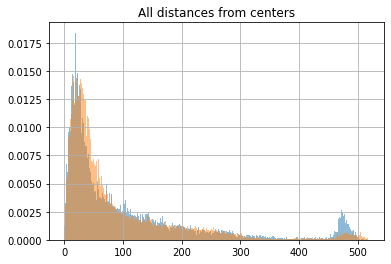

In [32]:
df.loc[(df.PhaseType == 1) & (df.nLocs == 5)].FixationR.hist(
    bins=300, alpha=0.5, density=True, label='5 Letters/Numbers')
df.loc[(df.PhaseType == 1) & (df.nLocs == 6)].FixationR.hist(
    bins=300, alpha=0.5, density=True, label='6 Letters/Numbers')
plt.title('All distances from centers');

In [176]:
np.nanquantile(df.loc[(df.PhaseType == 1) & (df.nLocs == 5)].FixationR.values, 0.75)

152.11837495845134

In [177]:
np.nanquantile(df.loc[(df.PhaseType == 1) & (df.nLocs == 6)].FixationR.values, 0.75)

128.96898852049662

In [19]:
# for subj in df.ID.unique():
#     print(subj)
#     df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 5)].FixationR.hist(bins=300, alpha=0.5, density=True)
#     df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 6)].FixationR.hist(bins=300, alpha=0.5, density=True)
#     plt.show()
#     print()

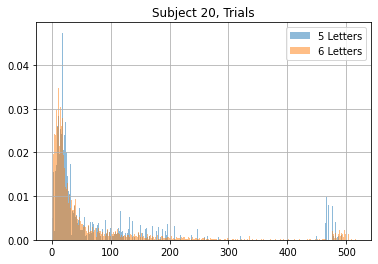

In [33]:
subj = np.random.choice(df.ID.unique())
df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 5)].FixationR.hist(
    bins=300, alpha=0.5, density=True, label='5 Letters')
df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 6)].FixationR.hist(
    bins=300, alpha=0.5, density=True, label='6 Letters')
plt.title('Subject ' + str(subj) + ', Trials')
plt.legend();

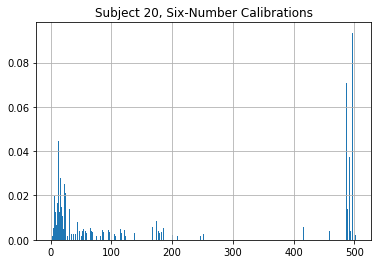

In [34]:
df.loc[(df.ID == subj) & (df.PhaseType == 0) & (df.MediaName.isin(['123456_1', '123456_2']))
        ].FixationR.hist(bins=300, density=True)
plt.title('Subject ' + str(subj) + ', Six-Number Calibrations');

In [ ]:
### for subj in df.ID.unique():
#     print(subj)
#     df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 5)].FixationR.hist(bins=300, alpha=0.5, density=True)
#     df.loc[(df.ID == subj) & (df.PhaseType == 1) & (df.nLocs == 6)].FixationR.hist(bins=300, alpha=0.5, density=True)
#     plt.show()
#     print()

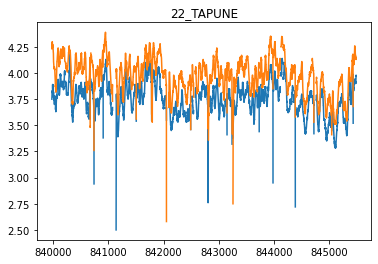

In [253]:
p = np.random.choice(df.PhaseName.unique())
df.loc[(df.PhaseName == p)].PupilLeft.plot()
df.loc[(df.PhaseName == p)].PupilRight.plot()
plt.title(p)
plt.show()

#### Split by radius

In [36]:
df5 = df.loc[(df.PhaseType > -1) & (df.nLocs == 5)]

df6 = df.loc[(df.PhaseType > -1) & (df.nLocs == 6)]

dfb = df.loc[(df.PhaseType < 0)]

### Sample demo of what will be done for each participant

In [207]:
# Minimum radius for 5 letter words
RADIUS5 = 150
# Minimum number of milliseconds to be within the radius for Gaze
GAZEMIN = 150

In [160]:
np.random.choice(df5.PhaseName.unique())

'22_RUCTO'

In [161]:
p = '10_CTUOR'

dfs = df5.loc[df5.PhaseName == p]

In [162]:
# Suppress unnecessary warning
pd.options.mode.chained_assignment = None  # default='warn'

In [163]:
# Apply the radius, location 0 is 'in-between' the locations
dfs.GazeLoc = dfs.apply(lambda row: 0 if row.GazeR > RADIUS5 else row.GazeLoc, axis=1)
dfs.FixationLoc = dfs.apply(lambda row: 0 if row.FixationR > RADIUS5 else row.FixationLoc, axis=1)

In [165]:
# Set Gaze location number (needed for `goupby`)
dfsg = dfs.dropna(subset=['GazeLoc'])
# Check if the next index disagrees with the current index
idxs = dfsg.index[(dfsg.GazeLoc.shift(periods=1) != dfsg.GazeLoc)]
dfs['GazeLocN'] = np.zeros(dfs.shape[0])
dfs.loc[idxs, 'GazeLocN'] = 1
dfs.GazeLocN = np.cumsum(dfs.GazeLocN)

In [166]:
# Do the same for Fixation
dfsf = dfs.dropna(subset=['FixationLoc'])
idxs = dfsf.index[(dfsf.FixationLoc.shift(periods=1) != dfsf.FixationLoc)]
dfs['FixationLocN'] = np.zeros(dfs.shape[0])
dfs.loc[idxs, 'FixationLocN'] = 1
dfs.FixationLocN = np.cumsum(dfs.FixationLocN)

##### Get a look

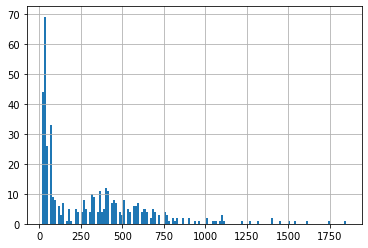

In [201]:
(dfs.groupby('GazeLocN').Timestamp.max() - dfs.groupby('GazeLocN').Timestamp.min() + 17).hist(bins=150)

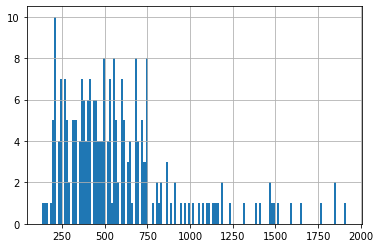

In [191]:
(dfs.groupby('FixationLocN').Timestamp.max() - dfs.groupby('FixationLocN').Timestamp.min() + 17).hist(bins=150)

#### What to return?

In [209]:
dfsGG = dfs.groupby('GazeLocN')
dfsFG = dfs.groupby('FixationLocN')

In [257]:
dfsGGDur = dfsGG.Timestamp.max() - dfsGG.Timestamp.min() + 17

In [260]:
dfsGGLoc = dfsGG.GazeLoc.mean()

In [265]:
dfsGGPupLmean = dfsGG.PupilLeft.mean()

dfsGGPupLmed = dfsGG.PupilLeft.median()

dfsGGPupLstd = dfsGG.PupilLeft.std()

In [269]:
dfsGGPupRmean = dfsGG.PupilRight.mean()

dfsGGPupRmed = dfsGG.PupilRight.median()

dfsGGPupRstd = dfsGG.PupilRight.std()

In [224]:
dfs.columns

Index(['ID', 'Date', 'MediaName', 'EventType', 'EventDuration', 'FixationX',
       'FixationY', 'GazeX', 'GazeY', 'DistanceLeft', 'DistanceRight',
       'EyePosLeftX', 'EyePosLeftY', 'EyePosLeftX.1', 'EyePosRightX',
       'EyePosRightY', 'EyePosRightZ', 'ValidityLeft', 'ValidityRight',
       'PupilLeft', 'PupilRight', 'PhaseName', 'Timestamp', 'FixationN',
       'SaccadeN', 'GazeLoc', 'GazeR', 'GazeTheta', 'FixationLoc', 'FixationR',
       'FixationTheta', 'PhaseType', 'nLocs', 'GazeLocN', 'FixationLocN'],
      dtype='object')

In [205]:
dfsgDurs.loc[dfsgDurs < 150].index

Float64Index([  3.0,   5.0,   7.0,   8.0,  11.0,  13.0,  15.0,  17.0,  19.0,
               23.0,
              ...
              414.0, 415.0, 420.0, 422.0, 424.0, 426.0, 430.0, 432.0, 433.0,
              436.0],
             dtype='float64', name='GazeLocN', length=198)

In [216]:
dfs

,ID,Date,MediaName,EventType,EventDuration,FixationX,FixationY,GazeX,GazeY,DistanceLeft,...,GazeLoc,GazeR,GazeTheta,FixationLoc,FixationR,FixationTheta,PhaseType,nLocs,GazeLocN,FixationLocN
420136,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420137,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420138,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420139,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420140,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428329,10,11/12/2019,CTUOR,1.0,133.0,231.0,1001.0,232.0,998.0,560.16,...,0.0,219.738481,-85.301319,0.0,221.0,-84.547378,1,5,438.0,234.0
428330,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,289.0,940.0,559.86,...,0.0,166.865215,-103.869686,NaN,NaN,NaN,1,5,438.0,234.0
428331,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,470.0,727.0,559.57,...,0.0,253.712436,175.705217,NaN,NaN,NaN,1,5,438.0,234.0
428332,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,568.0,533.0,559.19,...,0.0,462.058438,165.332175,NaN,NaN,NaN,1,5,438.0,234.0


In [134]:
df.loc[df.PhaseName == '28_Black_Screen'].Timestamp.diff().unique()

array([        nan, 1.70000e+01, 1.60000e+01, 1.80000e+01, 1.50000e+01,
       1.40000e+01, 3.22211e+05])

In [ ]:
# dfs.FixationLoc.value_counts()
# dfs.groupby('FixationLocN').FixationR.mean().hist(bins=300)

In [103]:
df.EventDuration.value_counts().sort_values(ascending=False).iloc[:20]

150.0    70084
167.0    69692
183.0    69411
200.0    63137
67.0     60529
83.0     57753
133.0    53665
233.0    50183
50.0     49599
100.0    45872
33.0     44745
250.0    43436
117.0    41244
17.0     40468
217.0    39936
283.0    36009
300.0    33644
316.0    27751
266.0    27520
333.0    26735
Name: EventDuration, dtype: int64

In [104]:
df.Timestamp.diff().value_counts().sort_values(ascending=False).iloc[:20]

 17.0        997091
 16.0        526349
 18.0          1762
 15.0          1292
 14.0           244
 19.0            23
 12.0             2
 20.0             2
-212275.0         2
-212075.0         2
-8910.0           1
-12224.0          1
-169440.0         1
-10425.0          1
-166210.0         1
-152987.0         1
-8860.0           1
-157216.0         1
-8960.0           1
 146808.0         1
Name: Timestamp, dtype: int64

In [108]:
list(zip(dfs.groupby('GazeLocN').GazeR.count().sort_values().iloc[:40].tolist(), 
           dfs.groupby('GazeLocN').EventDuration.std().sort_values().iloc[:40].tolist()))

[(0, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0),
 (1, 0.0)]

In [76]:
dfs

,ID,Date,MediaName,EventType,EventDuration,FixationX,FixationY,GazeX,GazeY,DistanceLeft,...,GazeLoc,GazeR,GazeTheta,FixationLoc,FixationR,FixationTheta,PhaseType,nLocs,GazeLocN,FixationLocN
420136,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420137,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420138,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420139,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
420140,10,11/12/2019,CTUOR,NaN,217.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428329,10,11/12/2019,CTUOR,1.0,133.0,231.0,1001.0,232.0,998.0,560.16,...,0.0,219.738481,-85.301319,0.0,221.0,-84.547378,1,5,438.0,234.0
428330,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,289.0,940.0,559.86,...,0.0,166.865215,-103.869686,NaN,NaN,NaN,1,5,438.0,234.0
428331,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,470.0,727.0,559.57,...,0.0,253.712436,175.705217,NaN,NaN,NaN,1,5,438.0,234.0
428332,10,11/12/2019,CTUOR,0.0,100.0,NaN,NaN,568.0,533.0,559.19,...,0.0,462.058438,165.332175,NaN,NaN,NaN,1,5,438.0,234.0


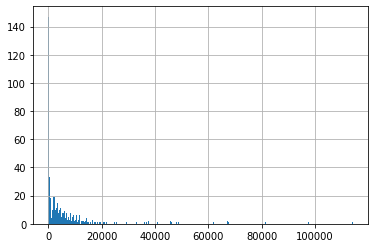

In [78]:
dfs.groupby('GazeLocN').EventDuration.sum().hist(bins=300)

In [60]:
dfs.groupby('FixationLocN').EventDuration.sum().sort_values()

FixationLocN
67.0        666.0
107.0       749.0
28.0        766.0
167.0       885.0
123.0       969.0
           ...   
183.0     68160.0
157.0     76765.0
50.0      81383.0
198.0     97897.0
148.0    114359.0
Name: EventDuration, Length: 235, dtype: float64

### Steps

1. Iterate by `PhaseName`
2. If Gaze radius and? Fixation radius are greater than some set number of pixels, set the location to 0. 
3. If the shifted Loc is not equal to the Loc, and the regular Loc is not NaN, save those indices.
3. Make a LocChange column, set the entries of those indices equal to 1 (the rest being zero). 
4. Make a cumulative sum of that column, so that each 
